# Prologue

Forecasting short-term rainfall/precipitation from historical data from the past 20 years using ARIMA model. The expected output is to get the best parameters in the modeling so that the model can be used for forecasting rainfall.

Why is rainfall estimation important?
It is important to accurately estimate rainfall for effective use of water resources and optimal planning of water structures.

# Import Library and Dataset

As mentioned earlier, this project aims to calculate the estimation of rainfall amounts (monthly rain average in mm/day) for the next five years after 2019 since the latest data that we have is in 2019. Here is the following libraries will be used to perform the analysis.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The data used in this analysis are from Giovanni. Giovanni is a Web interface that allows users to analyze NASA's gridded data from various satellite and surface observations. 

In [3]:
## Import data from google drive
df = pd.read_csv('/content/drive/MyDrive/g4.areaAvgTimeSeries.TRMM_3B42_Daily_7_precipitation.19990101-20190101.180W_50S_180E_50N.csv')

## Read and Understand the Data

The downloaded dataset contains two columns and 7313 rows. As we can see, the dataset is a bit messy, so we need to figure out which row of data to start with.

In [4]:
## Print out the raw data
df

,Title:,"Time Series, Area-Averaged of Precipitation Rate daily 0.25 deg. [TRMM ()"
0,User Start Date:,1999-01-01T00:00:00Z
1,User End Date:,2019-01-01T23:59:59Z
2,User Bounding Box:,NaN
3,Data Bounding Box:,NaN
4,URL to Reproduce Results:,https://giovanni.gsfc.nasa.gov/giovanni/#servi...
...,...,...
7308,2018-12-28,7.19602013
7309,2018-12-29,6.30557919
7310,2018-12-30,7.00499153
7311,2018-12-31,4.82450294


From the code below, we nocite that the precipitation data we will use starts from the 7th rows.

In [5]:
## Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7313 entries, 0 to 7312
Data columns (total 2 columns):
 #   Column                                                                     Non-Null Count  Dtype 
---  ------                                                                     --------------  ----- 
 0   Title:                                                                     7313 non-null   object
 1   Time Series, Area-Averaged of Precipitation Rate daily 0.25 deg. [TRMM ()  7311 non-null   object
dtypes: object(2)
memory usage: 114.4+ KB


In [6]:
## Print out the first 10 rows to find out the unnecessary rows
df.head(10)

,Title:,"Time Series, Area-Averaged of Precipitation Rate daily 0.25 deg. [TRMM ()"
0,User Start Date:,1999-01-01T00:00:00Z
1,User End Date:,2019-01-01T23:59:59Z
2,User Bounding Box:,NaN
3,Data Bounding Box:,NaN
4,URL to Reproduce Results:,https://giovanni.gsfc.nasa.gov/giovanni/#servi...
5,Fill Value (mean_TRMM_3B42_Daily_7_precipitati...,-9999.9
6,time,mean_TRMM_3B42_Daily_7_precipitation
7,1999-01-01,14.9035263
8,1999-01-02,11.4257498
9,1999-01-03,7.94812012


Create a new dataframe contains data from the 7th rows. 

In [7]:
## The data needed started from the 7th rows
df2 = df.tail(-7)
df2

,Title:,"Time Series, Area-Averaged of Precipitation Rate daily 0.25 deg. [TRMM ()"
7,1999-01-01,14.9035263
8,1999-01-02,11.4257498
9,1999-01-03,7.94812012
10,1999-01-04,12.7407541
11,1999-01-05,8.8068037
...,...,...
7308,2018-12-28,7.19602013
7309,2018-12-29,6.30557919
7310,2018-12-30,7.00499153
7311,2018-12-31,4.82450294


Here is the description of the data we have
- First column is the date
- Second column is the amount of the precipitation (daily average of precipitation in mm/day)

In [8]:
## Rename the columns into Date and Precipitation
## The data in Precipitation column is the daily average of rainfall in Indonesia

df2.columns = ["Date", "Precipitation"]
df2

,Date,Precipitation
7,1999-01-01,14.9035263
8,1999-01-02,11.4257498
9,1999-01-03,7.94812012
10,1999-01-04,12.7407541
11,1999-01-05,8.8068037
...,...,...
7308,2018-12-28,7.19602013
7309,2018-12-29,6.30557919
7310,2018-12-30,7.00499153
7311,2018-12-31,4.82450294


## Changing Data Types

In [9]:
## Convert 'Date' value into datetime
## Convert 'Precipitation' value into numeric
df2['Date'] = pd.to_datetime(df2['Date'])
df2['Precipitation'] = pd.to_numeric(df2['Precipitation'])
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Date,Precipitation
7,1999-01-01,14.903526
8,1999-01-02,11.425750
9,1999-01-03,7.948120
10,1999-01-04,12.740754
11,1999-01-05,8.806804
...,...,...
7308,2018-12-28,7.196020
7309,2018-12-29,6.305579
7310,2018-12-30,7.004992
7311,2018-12-31,4.824503


In [10]:
## Crosscheck the data
## Make sure the data doesn't contain missing value
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306 entries, 7 to 7312
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7306 non-null   datetime64[ns]
 1   Precipitation  7306 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 114.3 KB


## Exploratory Data Analysis

[Text(0.5, 1.0, 'Precipitation Distribution')]

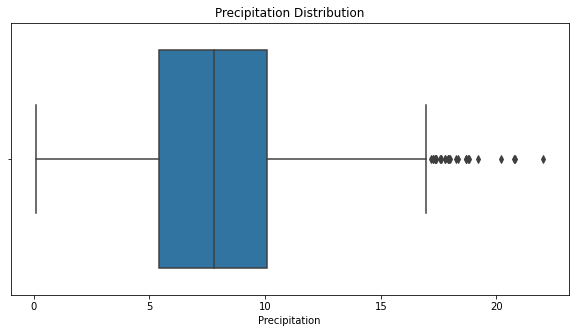

In [11]:
## Precipitation distribution in boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x="Precipitation", data = df2).set(title = 'Precipitation Distribution')

[Text(0.5, 1.0, 'Rainfall Timeseries from 01-Jan-1999 until 01-Jan-2019')]

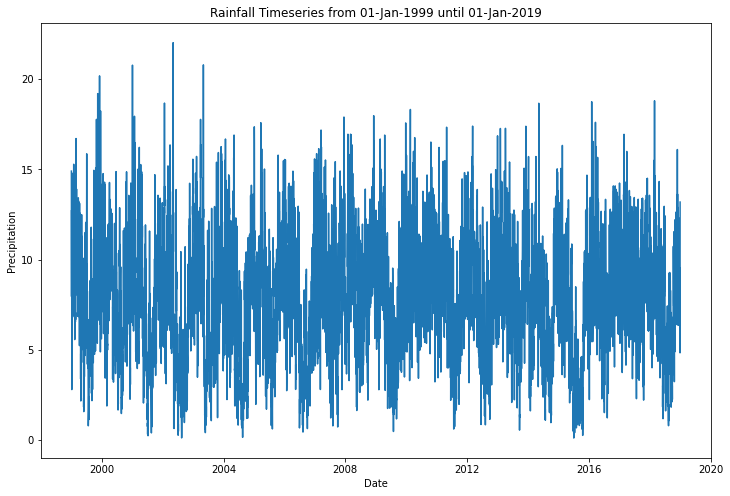

In [12]:
## Plot the precipitation timeseries from 1999 until 2019
plt.figure(figsize=(12,8))
sns.lineplot(x="Date", y="Precipitation", data = df2).set(title = 'Rainfall Timeseries from 01-Jan-1999 until 01-Jan-2019')

In [13]:
## Calculate the monthly average of rainfall
df3 = df2.groupby(pd.PeriodIndex(df2['Date'], freq="M"))['Precipitation'].mean().reset_index()
df3["month"] = df3['Date'].map(lambda x: x.month)
df3["year"] = df3['Date'].map(lambda x: x.year)
df3

,Date,Precipitation,month,year
0,1999-01,10.000398,1,1999
1,1999-02,9.691330,2,1999
2,1999-03,10.648398,3,1999
3,1999-04,8.398030,4,1999
4,1999-05,7.350341,5,1999
...,...,...,...,...
236,2018-09,5.048592,9,2018
237,2018-10,6.844830,10,2018
238,2018-11,9.226878,11,2018
239,2018-12,9.107919,12,2018


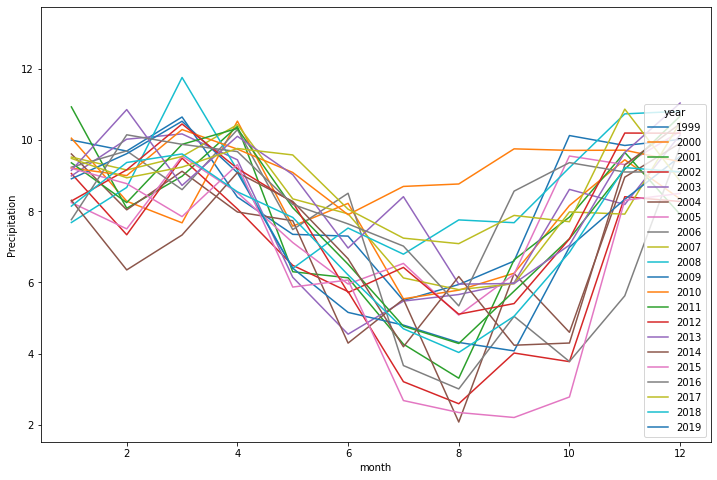

In [14]:
## Plot the timeseries in lineplot for each year
plt.figure(figsize=(12,8))
sns.lineplot(x='month',y='Precipitation',hue='year',data=df3, palette='tab10')

In [15]:
## Creating lineplot with column 'Date' (which just represent the month and the year) as an axis causing an error 
## Convert 'Date' column into datetime64[M] to handle the error
df3['dates'] = df3.Date.values.astype('datetime64[M]')
df3

,Date,Precipitation,month,year,dates
0,1999-01,10.000398,1,1999,1999-01-01
1,1999-02,9.691330,2,1999,1999-02-01
2,1999-03,10.648398,3,1999,1999-03-01
3,1999-04,8.398030,4,1999,1999-04-01
4,1999-05,7.350341,5,1999,1999-05-01
...,...,...,...,...,...
236,2018-09,5.048592,9,2018,2018-09-01
237,2018-10,6.844830,10,2018,2018-10-01
238,2018-11,9.226878,11,2018,2018-11-01
239,2018-12,9.107919,12,2018,2018-12-01


[Text(0.5, 1.0, 'Monthly Average of Rainfall from 01-Jan-1999 until 01-Jan-2019')]

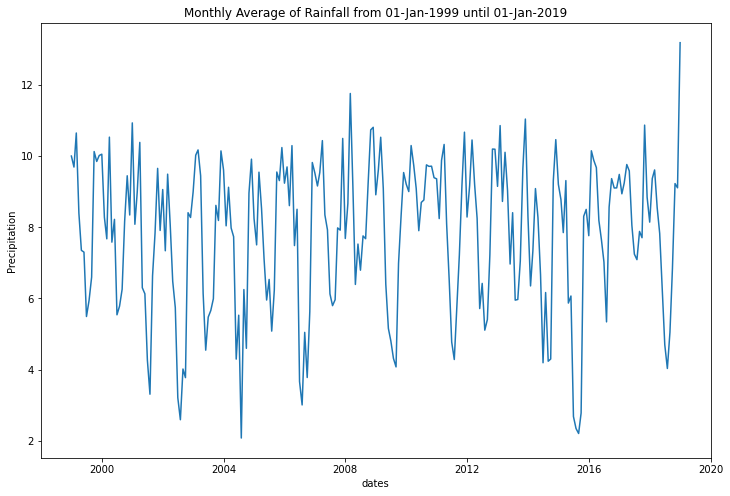

In [16]:
## Plot monthly average of rainfall in a lineplot
plt.figure(figsize=(12,8))
sns.lineplot(x="dates", y="Precipitation", data = df3).set(title = 'Monthly Average of Rainfall from 01-Jan-1999 until 01-Jan-2019')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


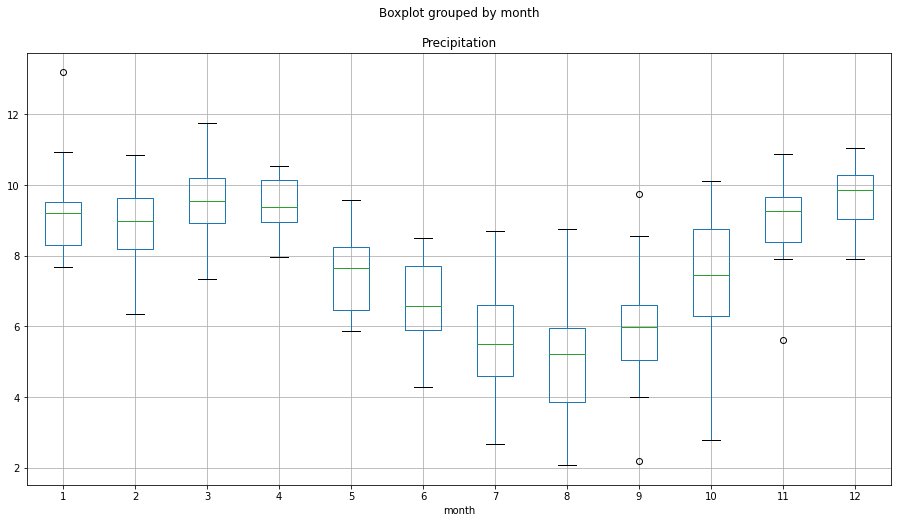

In [17]:
## Distribution of the rainfall in every month from 1999 until 2019
df3.boxplot(figsize=(15,8),by='month',column='Precipitation')

In [18]:
## break down the data into three portions, trend, seasonality, and random residual components
## use the Multiplicative model since the trend and seasonal are variated over time
df3.set_index('dates',inplace=True)
result=seasonal_decompose(df3['Precipitation'],model='multiplicable')

Text(0.5, 0.98, 'Time Series Decomposition')

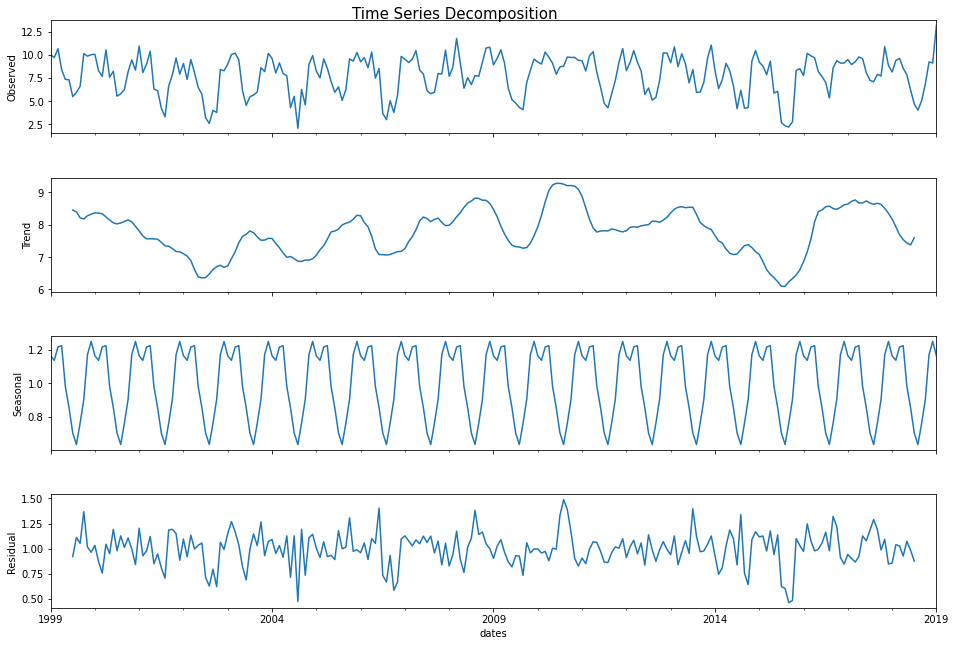

In [19]:
## create time series decomposition to see the trend and seasonality
fig = result.plot()
fig.set_size_inches(15,10)
fig.suptitle("Time Series Decomposition", fontsize = 15)

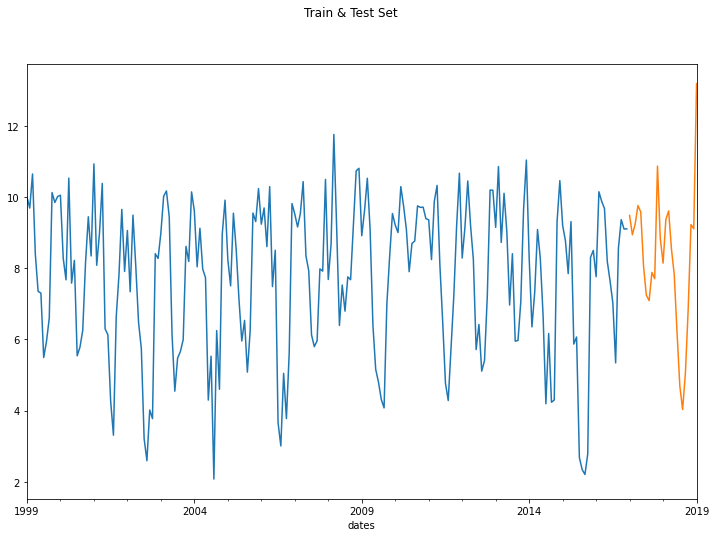

In [20]:
## Split data into train & test set
train, test = df3['Precipitation'][:216], df3['Precipitation'][216:]
n = len(df3)
n_train = len(train)
n_test = len(test)

## Plot train & test set
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Train & Test Set")
train.plot(ax=ax);
test.plot(ax=ax);

In [21]:
from statsmodels.tsa.stattools import adfuller
X = df3['Precipitation']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.766889
p-value: 0.003265
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


In [22]:
series = df3.loc[:, 'Precipitation'].values
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(series)

KPSS Statistic: 0.09793635785108902
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


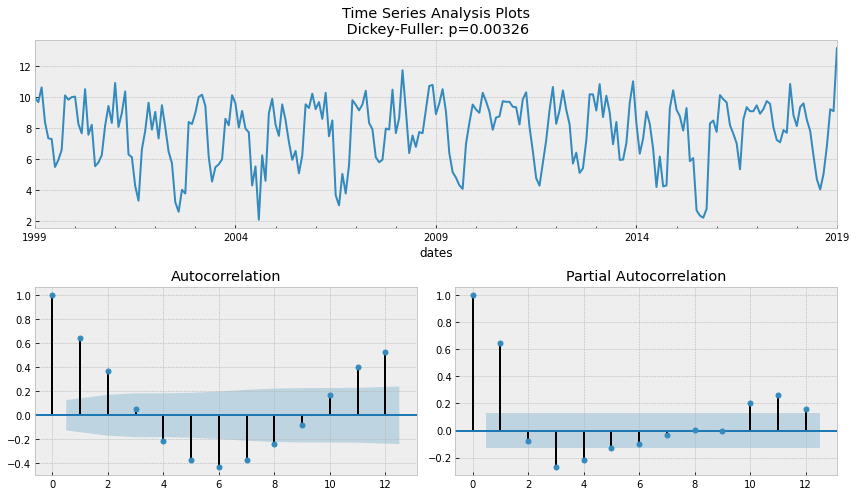

In [23]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df3.Precipitation, lags=12)

In [24]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 3
p = q = range(0,3)
d = range(0,1)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [33]:
pdq[1]

(0, 0, 1)

In [25]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df3.Precipitation,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1693.5322474199647
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1474.8896216079195
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1352.8077792573918
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1048.2690376173314
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:923.6884273852249
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:924.988367045047
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:989.776141757163
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:927.2316221864545
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:926.2865973399025
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1442.1517048732567
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1292.4313411697226
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:1208.9437793178956
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:997.5529625906856
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:888.5052980271437
ARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:889.9739681206534
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:944.2477273747713
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:890.4991262074159
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:1290.0674432818619
ARIM

In [37]:
 mod = sm.tsa.statespace.SARIMAX(df3.Precipitation,
                                order=(2, 0, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6890      0.138     12.237      0.000       1.418       1.959
ar.L2         -0.6921      0.140     -4.952      0.000      -0.966      -0.418
ma.L1         -1.2657      0.171     -7.405      0.000      -1.601      -0.931
ma.L2          0.3006      0.153      1.963      0.050       0.001       0.601
ar.S.L12       0.9981      0.004    237.789      0.000       0.990       1.006
ma.S.L12      -0.9311      0.074    -12.580      0.000      -1.076      -0.786
sigma2         1.5657      0.178      8.815      0.000       1.218       1.914


In [27]:
len(train),(len(df3)-1)

(216, 240)

In [38]:
pred = results.predict(start=len(train),end=(len(df3)-1))
print(pred)
type(pred)

2017-01-01     8.785059
2017-02-01     8.952404
2017-03-01     9.426095
2017-04-01     9.332240
2017-05-01     7.659451
2017-06-01     7.565640
2017-07-01     6.544665
2017-08-01     6.076486
2017-09-01     7.131607
2017-10-01     8.288240
2017-11-01     9.685240
2017-12-01    10.761814
2018-01-01     9.043166
2018-02-01     8.544941
2018-03-01     9.541263
2018-04-01     9.639241
2018-05-01     7.458220
2018-06-01     6.813988
2018-07-01     5.610226
2018-08-01     4.786447
2018-09-01     5.456511
2018-10-01     6.459888
2018-11-01     8.780343
2018-12-01     9.536303
2019-01-01     8.663452
Freq: MS, dtype: float64


pandas.core.series.Series

In [39]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(test,pred)
mse = metrics.mean_squared_error(test,pred)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = metrics.r2_score(test,pred)

print("Results of sklearn.metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.8643982638137615
MSE: 1.5159559433826184
RMSE: 1.231241626725891
R-Squared: 0.5940238370457117


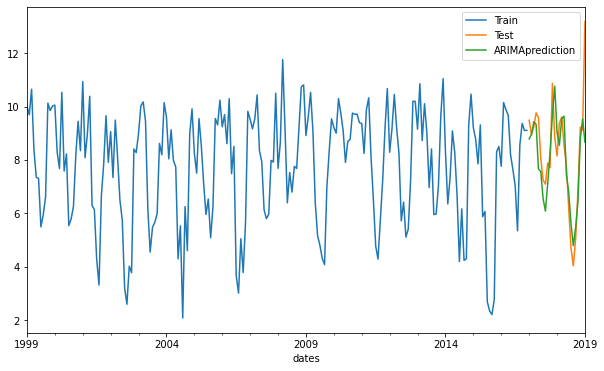

In [40]:
train.plot(legend=True, label='Train',figsize=(10,6))
test.plot(legend=True, label='Test')
pred.plot(legend=True, label='ARIMAprediction')

In [41]:
prediction = results.predict(start=len(df3),end=(len(df3)+36))
print(prediction)
type(prediction)

2019-02-01    10.565449
2019-03-01    10.650434
2019-04-01    10.338515
2019-05-01     8.496818
2019-06-01     7.395534
2019-07-01     6.270728
2019-08-01     5.664972
2019-09-01     6.463257
2019-10-01     7.478121
2019-11-01     9.465977
2019-12-01     9.887166
2020-01-01     9.526007
2020-02-01     9.264503
2020-03-01     9.726123
2020-04-01     9.678394
2020-05-01     8.024630
2020-06-01     7.054503
2020-07-01     6.022180
2020-08-01     5.480840
2020-09-01     6.321931
2020-10-01     7.365943
2020-11-01     9.371832
2020-12-01     9.807556
2021-01-01     9.457887
2021-02-01     9.204512
2021-03-01     9.670669
2021-04-01     9.626894
2021-05-01     7.979052
2021-06-01     7.012787
2021-07-01     5.983911
2021-08-01     5.444711
2021-09-01     6.285051
2021-10-01     7.327742
2021-11-01     9.330351
2021-12-01     9.765691
2022-01-01     9.417067
2022-02-01     9.164509
Freq: MS, dtype: float64


pandas.core.series.Series

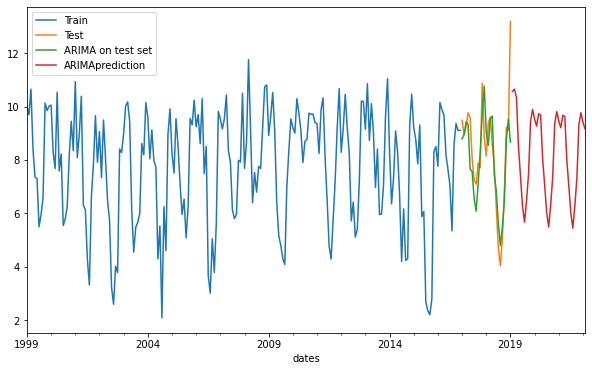

In [42]:
train.plot(legend=True, label='Train',figsize=(10,6))
test.plot(legend=True, label='Test')
pred.plot(legend=True, label='ARIMA on test set')
prediction.plot(legend=True, label='ARIMAprediction')